In [2]:
#!pip install tensorflow-metal
#!pip install tensorflow-macos

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import tensorflow as tf
import keras.layers
from keras import layers,models
from keras.layers import Dense, Dropout
from keras import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
import keras

In [6]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [7]:
pretrained_model = keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2024-09-09 12:56:47.797660: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-09-09 12:56:47.797682: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-09-09 12:56:47.797691: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-09-09 12:56:47.797710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 12:56:47.797725: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "./CornLeafDiseaseImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4188 files belonging to 4 classes.
Using 3351 files for training.
Using 837 files for validation.


In [9]:
checkpoint_path = "corn_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])


inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        #steps_per_epoch=100,
        validation_data=val_ds,
        #validation_steps=50,
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("training_logs", 
                                        "corn_classification"),
            checkpoint_callback,
        ],
        verbose=1
    )

Saving TensorBoard log files to: training_logs/corn_classification/20240909-125648
Epoch 1/100


2024-09-09 12:56:49.633025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 402ms/step - accuracy: 0.2959 - loss: 1.5805 - val_accuracy: 0.3943 - val_loss: 1.3152
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.3593 - loss: 1.4015 - val_accuracy: 0.6010 - val_loss: 1.1487
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - accuracy: 0.4642 - loss: 1.2382 - val_accuracy: 0.7145 - val_loss: 1.0173
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.5479 - loss: 1.1171 - val_accuracy: 0.7563 - val_loss: 0.9114
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.6362 - loss: 0.9909 - val_accuracy: 0.7742 - val_loss: 0.8237
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.6894 - loss: 0.8986 - val_accuracy: 0.7921 - val_loss: 0.7505
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.7064 - loss: 0.8556 - val_accuracy: 0.7993 - val_loss: 0.6895
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.7481 - loss: 0.7664 - val_accuracy: 0.811

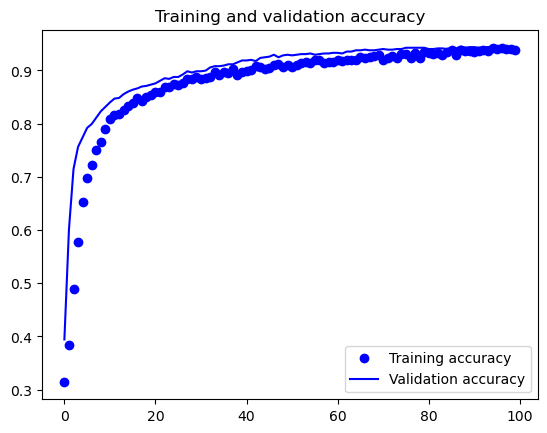

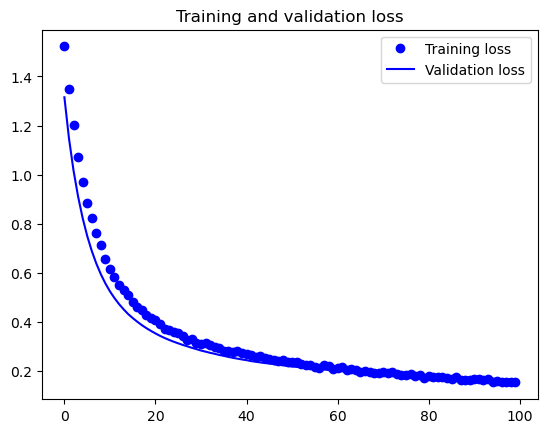

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [12]:
model.save("./models/leaf.corn.mobilenetv3large.keras")
reconstructed_model = keras.models.load_model("./models/leaf.corn.mobilenetv3large.keras")